# Análisis del Índice de Desarrollo Humano (HDI)

Este notebook resume el análisis realizado para el proyecto de **Desarrollo Humano**, usando la base de datos del *Human Development Index* (HDI) obtenida de Kaggle.  
Aquí se documentan los pasos principales:

1. Carga y limpieza de datos  
2. Análisis exploratorio (EDA)  
3. Tendencias del HDI en el tiempo  
4. Relación entre el HDI y variables socioeconómicas clave  
5. Construcción de un modelo sencillo de Machine Learning para predecir el HDI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use("default")

## 1. Carga de datos

La base de datos se encuentra en la carpeta `Data` con el nombre **HumanDevelopmentIndex.csv**.  
Primero la cargamos y damos un vistazo a su estructura general.

In [2]:
# Ruta al archivo (ajusta si tu estructura de carpetas es distinta)
data_path = "Data/HumanDevelopmentIndex.csv"

df_raw = pd.read_csv(data_path)
df_raw.head()

,ISO3,Country,Human Development Groups,UNDP Developing Regions,HDI Rank (2021),Human Development Index (1990),Human Development Index (1991),Human Development Index (1992),Human Development Index (1993),Human Development Index (1994),...,Material footprint per capita (tonnes) (2012),Material footprint per capita (tonnes) (2013),Material footprint per capita (tonnes) (2014),Material footprint per capita (tonnes) (2015),Material footprint per capita (tonnes) (2016),Material footprint per capita (tonnes) (2017),Material footprint per capita (tonnes) (2018),Material footprint per capita (tonnes) (2019),Material footprint per capita (tonnes) (2020),Material footprint per capita (tonnes) (2021)
0,AFG,Afghanistan,Low,SA,180.0,0.273,0.279,0.287,0.297,0.292,...,1.86,1.88,1.66,1.62,1.66,1.41,1.32,1.38,1.38,1.38
1,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,...,4.09,4.53,3.97,3.59,2.79,2.64,2.28,2.18,2.18,2.18
2,ALB,Albania,High,ECA,67.0,0.647,0.629,0.614,0.617,0.624,...,12.44,11.49,13.14,12.61,14.39,14.46,12.85,12.96,12.96,12.96
3,AND,Andorra,Very High,NaN,40.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARE,United Arab Emirates,Very High,AS,26.0,0.728,0.739,0.742,0.748,0.755,...,49.56,49.68,55.49,59.76,64.95,75.61,65.97,68.95,68.95,68.95


## 2. Limpieza de datos

En esta sección se realiza una limpieza básica:

- Reemplazo de valores raros como `..`, `--`, `—` por `NaN`
- Eliminación de duplicados por país
- Conversión de columnas numéricas a tipo numérico
- Imputación de valores nulos numéricos con la mediana
- Imputación de valores nulos categóricos con la categoría `"Unknown"`

In [3]:
def clean_hdi_data(df):
    """Limpieza de dataset de HDI."""
    df = df.copy()

    # 1) Reemplazar valores raros por NaN
    df = df.replace({"..": np.nan, "--": np.nan, "—": np.nan})

    # 2) Eliminar duplicados por país
    if "Country" in df.columns:
        df = df.drop_duplicates(subset=["Country"], keep="first")

    # 3) Detectar columnas categóricas y numéricas
    cat_cols = ["Country", "Human Development Groups", "UNDP Developing Regions"]
    num_cols = [c for c in df.columns if c not in cat_cols]

    # 4) Conversión a numérico de columnas potencialmente numéricas
    for col in num_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "")
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="ignore")

    # 5) Rellenar nulos numéricos con la mediana
    for col in num_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())

    # 6) Rellenar nulos categóricos
    for c in ["Human Development Groups", "UNDP Developing Regions"]:
        if c in df.columns:
            df[c] = df[c].fillna("Unknown")

    return df


df = clean_hdi_data(df_raw)
df.head()

/var/folders/cb/v4v9k1yn78qf91xmdzfrcbwh0000gn/T/ipykernel_1009/715311928.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")
/var/folders/cb/v4v9k1yn78qf91xmdzfrcbwh0000gn/T/ipykernel_1009/715311928.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")
/var/folders/cb/v4v9k1yn78qf91xmdzfrcbwh0000gn/T/ipykernel_1009/715311928.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")
/var/folders/cb/v4v9k1yn78qf91xmdzfrcbwh0000gn/T/ipykernel_1009/715311928.py:24: FutureWarning: errors='ignore' is dep

,ISO3,Country,Human Development Groups,UNDP Developing Regions,HDI Rank (2021),Human Development Index (1990),Human Development Index (1991),Human Development Index (1992),Human Development Index (1993),Human Development Index (1994),...,Material footprint per capita (tonnes) (2012),Material footprint per capita (tonnes) (2013),Material footprint per capita (tonnes) (2014),Material footprint per capita (tonnes) (2015),Material footprint per capita (tonnes) (2016),Material footprint per capita (tonnes) (2017),Material footprint per capita (tonnes) (2018),Material footprint per capita (tonnes) (2019),Material footprint per capita (tonnes) (2020),Material footprint per capita (tonnes) (2021)
0,AFG,Afghanistan,Low,SA,180.0,0.273,0.279,0.287,0.297,0.292,...,1.86,1.88,1.66,1.62,1.66,1.41,1.32,1.38,1.38,1.38
1,AGO,Angola,Medium,SSA,148.0,nan,nan,nan,nan,nan,...,4.09,4.53,3.97,3.59,2.79,2.64,2.28,2.18,2.18,2.18
2,ALB,Albania,High,ECA,67.0,0.647,0.629,0.614,0.617,0.624,...,12.44,11.49,13.14,12.61,14.39,14.46,12.85,12.96,12.96,12.96
3,AND,Andorra,Very High,Unknown,40.0,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,ARE,United Arab Emirates,Very High,AS,26.0,0.728,0.739,0.742,0.748,0.755,...,49.56,49.68,55.49,59.76,64.95,75.61,65.97,68.95,68.95,68.95


In [4]:
# Resumen rápido de tipos de datos y nulos
print(df.info())
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Columns: 880 entries, ISO3 to Material footprint per capita (tonnes) (2021)
dtypes: float64(140), object(740)
memory usage: 1.3+ MB
None


ISO3                              0
Gender Inequality Index (1990)    0
Inequality in income (2012)       0
Inequality in income (2013)       0
Inequality in income (2014)       0
Inequality in income (2015)       0
Inequality in income (2016)       0
Inequality in income (2017)       0
Inequality in income (2018)       0
Inequality in income (2019)       0
dtype: int64

## 3. Transformación del HDI a formato largo

Para analizar la evolución del HDI a lo largo del tiempo, se convierten las columnas de HDI por año a un formato largo (`Country`, `Year`, `HDI`).

In [5]:
def get_hdi_columns(df):
    """Obtiene las columnas de HDI por año y las convierte a formato largo."""
    hdi_cols = [
        c for c in df.columns
        if c.startswith("Human Development Index (") and "Planetary" not in c
    ]
    years = [int(c.split("(")[1].split(")")[0]) for c in hdi_cols]

    hdi_long = df[["Country"] + hdi_cols].melt(
        id_vars="Country",
        value_vars=hdi_cols,
        var_name="Year",
        value_name="HDI"
    )
    hdi_long["Year"] = hdi_long["Year"].str.extract(r"(\d{4})").astype(int)

    # Asegurar HDI numérico
    hdi_long["HDI"] = (
        hdi_long["HDI"]
        .astype(str)
        .str.replace(",", "")
        .str.strip()
    )
    hdi_long["HDI"] = pd.to_numeric(hdi_long["HDI"], errors="coerce")

    return hdi_long, sorted(list(set(years)))


hdi_long, hdi_years = get_hdi_columns(df)
hdi_long.head()

,Country,Year,HDI
0,Afghanistan,1990,0.273
1,Angola,1990,NaN
2,Albania,1990,0.647
3,Andorra,1990,NaN
4,United Arab Emirates,1990,0.728


### 3.1 Tendencia global del HDI promedio

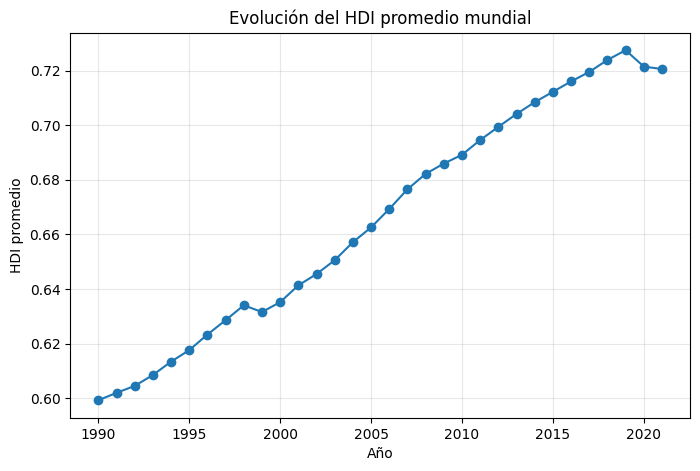

In [6]:
mean_hdi_per_year = hdi_long.groupby("Year")["HDI"].mean()

plt.figure(figsize=(8,5))
plt.plot(mean_hdi_per_year.index, mean_hdi_per_year.values, marker="o")
plt.title("Evolución del HDI promedio mundial")
plt.xlabel("Año")
plt.ylabel("HDI promedio")
plt.grid(True, alpha=0.3)
plt.show()

## 4. Análisis exploratorio 2021

Nos enfocamos ahora en el último año disponible (2021), creando un subconjunto con variables clave: HDI, GNI per cápita, esperanza de vida y educación.

In [7]:
def get_main_2021_df(df):
    cols = [
        "Country",
        "Human Development Groups",
        "UNDP Developing Regions",
        "Human Development Index (2021)",
        "Gross National Income Per Capita (2021)",
        "Life Expectancy at Birth (2021)",
        "Expected Years of Schooling (2021)",
        "Mean Years of Schooling (2021)"
    ]
    existing = [c for c in cols if c in df.columns]
    sub = df[existing].copy()

    sub = sub.rename(columns={
        "Human Development Groups": "HDI_Group",
        "UNDP Developing Regions": "Region",
        "Human Development Index (2021)": "HDI_2021",
        "Gross National Income Per Capita (2021)": "GNIpc_2021",
        "Life Expectancy at Birth (2021)": "LE_2021",
        "Expected Years of Schooling (2021)": "EYS_2021",
        "Mean Years of Schooling (2021)": "MYS_2021"
    })

    for col in ["HDI_2021", "GNIpc_2021", "LE_2021", "EYS_2021", "MYS_2021"]:
        if col in sub.columns:
            sub[col] = (
                sub[col]
                .astype(str)
                .str.replace(",", "")
                .str.strip()
            )
            sub[col] = pd.to_numeric(sub[col], errors="coerce")

    return sub


df_2021 = get_main_2021_df(df)
df_2021.head()

,Country,HDI_Group,Region,HDI_2021,GNIpc_2021,LE_2021,EYS_2021,MYS_2021
0,Afghanistan,Low,SA,0.478,1824.190915,61.9824,10.263844,2.985070
1,Angola,Medium,SSA,0.586,5465.617791,61.6434,12.172100,5.417391
2,Albania,High,ECA,0.796,14131.110390,76.4626,14.448000,11.286455
3,Andorra,Very High,Unknown,0.858,51166.626610,80.3684,13.300239,10.555120
4,United Arab Emirates,Very High,AS,0.911,62573.591810,78.7104,15.717690,12.694030


In [8]:
df_2021[["HDI_2021", "GNIpc_2021", "LE_2021", "EYS_2021", "MYS_2021"]].describe()

,HDI_2021,GNIpc_2021,LE_2021,EYS_2021,MYS_2021
count,191.000000,193.000000,195.000000,193.000000,191.000000
mean,0.720576,20136.391499,71.276330,13.510846,8.986916
std,0.150661,21756.087342,7.746488,2.918352,3.173693
min,0.385000,731.786709,52.525400,5.542510,2.114962
25%,0.599500,4566.303831,65.672500,11.549480,6.251659
50%,0.739000,12306.341000,71.694000,13.365385,9.306864
75%,0.835000,30027.291310,76.699300,15.599060,11.497702
max,0.962000,146829.700600,85.946300,21.054590,14.090967


### 4.1 Distribuciones de variables clave (2021)

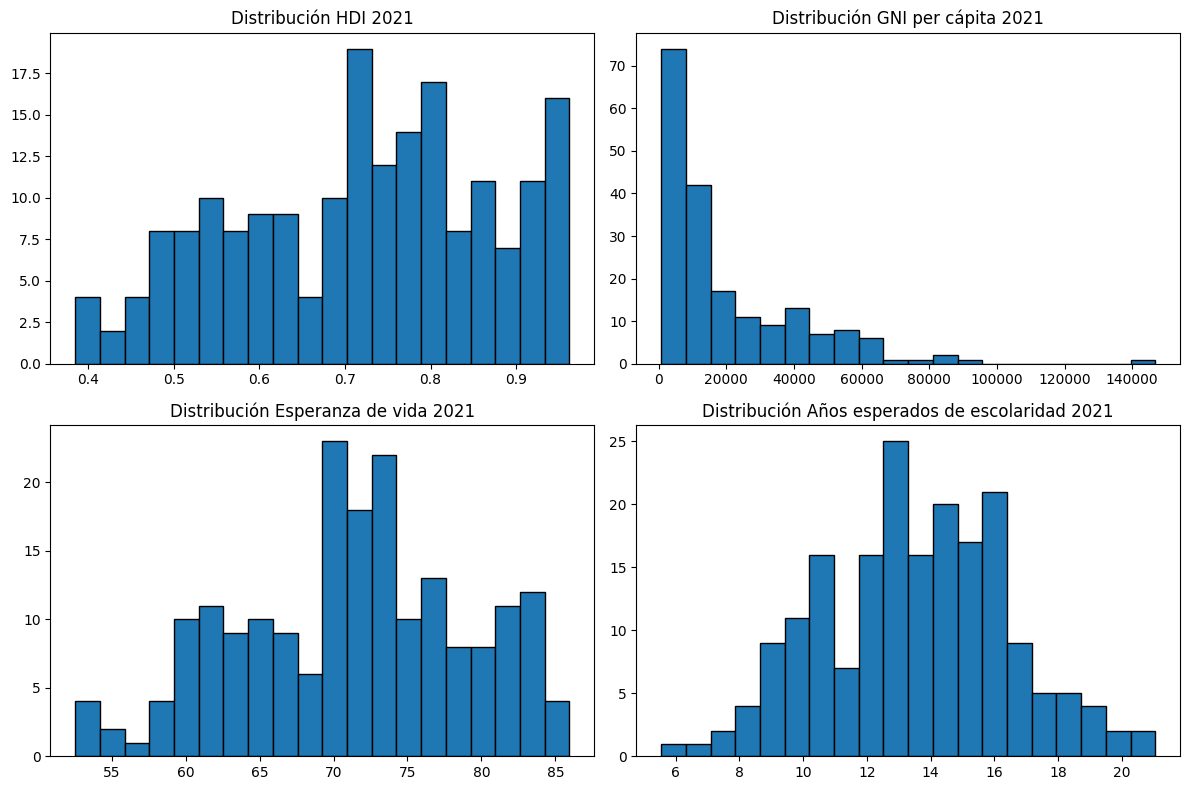

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes[0,0].hist(df_2021["HDI_2021"].dropna(), bins=20, edgecolor="black")
axes[0,0].set_title("Distribución HDI 2021")

axes[0,1].hist(df_2021["GNIpc_2021"].dropna(), bins=20, edgecolor="black")
axes[0,1].set_title("Distribución GNI per cápita 2021")

axes[1,0].hist(df_2021["LE_2021"].dropna(), bins=20, edgecolor="black")
axes[1,0].set_title("Distribución Esperanza de vida 2021")

axes[1,1].hist(df_2021["EYS_2021"].dropna(), bins=20, edgecolor="black")
axes[1,1].set_title("Distribución Años esperados de escolaridad 2021")

plt.tight_layout()
plt.show()

### 4.2 Relación entre ingreso y desarrollo humano (GNI vs HDI)

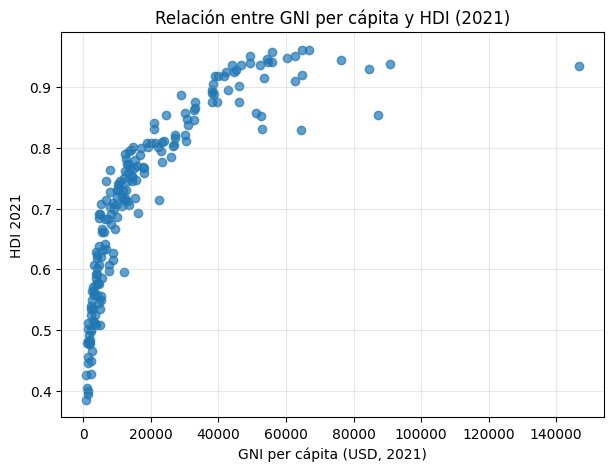

In [10]:
plt.figure(figsize=(7,5))
plt.scatter(df_2021["GNIpc_2021"], df_2021["HDI_2021"], alpha=0.7)
plt.xlabel("GNI per cápita (USD, 2021)")
plt.ylabel("HDI 2021")
plt.title("Relación entre GNI per cápita y HDI (2021)")
plt.grid(True, alpha=0.3)
plt.show()

## 5. Tendencias del HDI en el tiempo

Calculamos el cambio del HDI para cada país entre 1990 y 2021, clasificando a los países en:

- **Mejora importante** (ΔHDI ≥ 0.05)  
- **Retroceso** (ΔHDI ≤ -0.02)  
- **Estancado** (en el rango intermedio)

In [11]:
def compute_hdi_trends(df, start_year=1990, end_year=2021):
    hdi_long, _ = get_hdi_columns(df)
    hdi_period = hdi_long[hdi_long["Year"].between(start_year, end_year)].copy()

    hdi_period["HDI"] = pd.to_numeric(hdi_period["HDI"], errors="coerce")

    start_df = (
        hdi_period[hdi_period["Year"] == start_year][["Country", "HDI"]]
        .rename(columns={"HDI": "HDI_start"})
    )
    end_df = (
        hdi_period[hdi_period["Year"] == end_year][["Country", "HDI"]]
        .rename(columns={"HDI": "HDI_end"})
    )

    temp = pd.merge(start_df, end_df, on="Country", how="inner")

    for col in ["HDI_start", "HDI_end"]:
        temp[col] = pd.to_numeric(temp[col], errors="coerce")

    temp["HDI_change"] = temp["HDI_end"] - temp["HDI_start"]
    temp = temp.dropna(subset=["HDI_start", "HDI_end", "HDI_change"])

    mejora_umbral = 0.05
    empeora_umbral = -0.02

    categorias = []
    for delta in temp["HDI_change"]:
        if delta >= mejora_umbral:
            categorias.append("Mejora importante")
        elif delta <= empeora_umbral:
            categorias.append("Retroceso")
        else:
            categorias.append("Estancado")

    temp["Trend_Category"] = categorias
    return temp


trends_df = compute_hdi_trends(df, start_year=1990, end_year=2021)
trends_df.head()

,Country,HDI_start,HDI_end,HDI_change,Trend_Category
0,Afghanistan,0.273,0.478,0.205,Mejora importante
2,Albania,0.647,0.796,0.149,Mejora importante
4,United Arab Emirates,0.728,0.911,0.183,Mejora importante
5,Argentina,0.723,0.842,0.119,Mejora importante
6,Armenia,0.656,0.759,0.103,Mejora importante


In [12]:
trends_df["Trend_Category"].value_counts()

Trend_Category
Mejora importante    132
Estancado              9
Name: count, dtype: int64

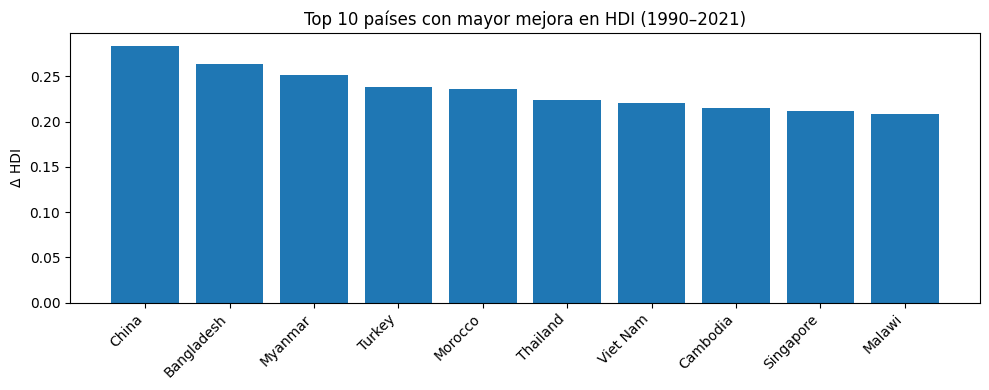

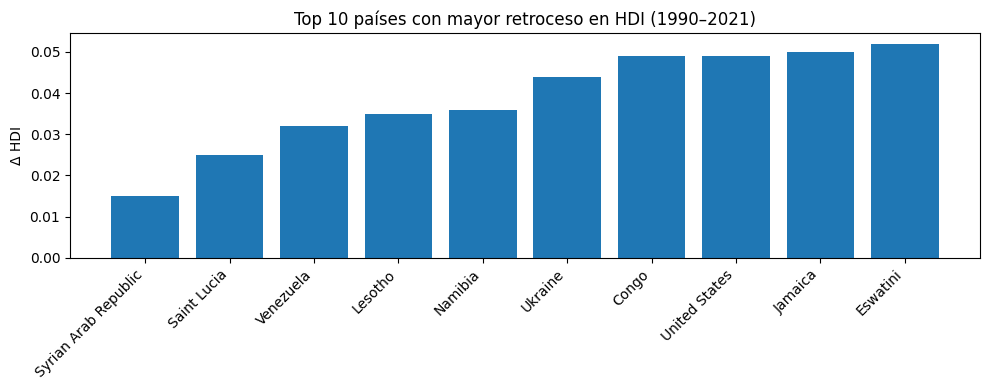

In [13]:
# Top 10 países que más mejoraron y empeoraron
top_up = trends_df.sort_values("HDI_change", ascending=False).head(10)
top_down = trends_df.sort_values("HDI_change", ascending=True).head(10)

plt.figure(figsize=(10,4))
plt.bar(top_up["Country"], top_up["HDI_change"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 países con mayor mejora en HDI (1990–2021)")
plt.ylabel("Δ HDI")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top_down["Country"], top_down["HDI_change"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 países con mayor retroceso en HDI (1990–2021)")
plt.ylabel("Δ HDI")
plt.tight_layout()
plt.show()

## 6. Correlación entre HDI y factores clave (2021)

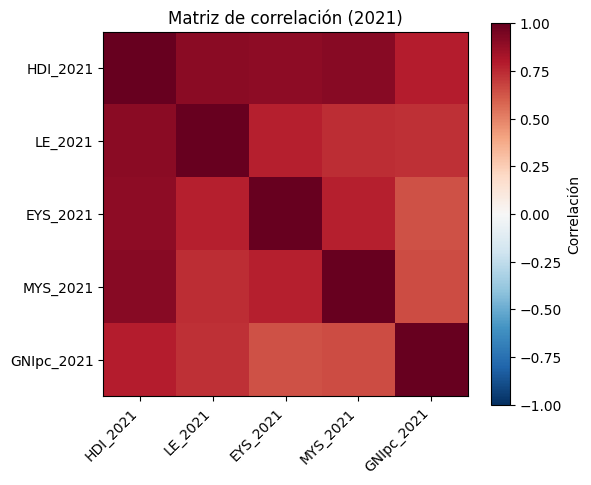

,HDI_2021,LE_2021,EYS_2021,MYS_2021,GNIpc_2021
HDI_2021,1.000000,0.905964,0.895600,0.909126,0.788036
LE_2021,0.905964,1.000000,0.777095,0.734408,0.733806
EYS_2021,0.895600,0.777095,1.000000,0.778543,0.638786
MYS_2021,0.909126,0.734408,0.778543,1.000000,0.650716
GNIpc_2021,0.788036,0.733806,0.638786,0.650716,1.000000


In [14]:
corr_cols = ["HDI_2021", "LE_2021", "EYS_2021", "MYS_2021", "GNIpc_2021"]
corr = df_2021[corr_cols].corr()

plt.figure(figsize=(6,5))
im = plt.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlación")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Matriz de correlación (2021)")
plt.tight_layout()
plt.show()

corr

## 7. Modelo de Machine Learning para predecir el HDI (2021)

Se construye un modelo sencillo de **regresión lineal** para predecir el HDI a partir de:

- GNI per cápita (2021)  
- Esperanza de vida (2021)  
- Años esperados de escolaridad (2021)  
- Años promedio de escolaridad (2021)

In [15]:
features = ["GNIpc_2021", "LE_2021", "EYS_2021", "MYS_2021"]
target = "HDI_2021"

data_ml = df_2021.dropna(subset=features + [target]).copy()

X = data_ml[features]
y = data_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train, rmse_test, r2_train, r2_test, mae_test

(np.float64(0.02096430866925647),
 np.float64(0.023884718014542436),
 0.9796611138459176,
 0.9773166437378153,
 0.018229080112230855)

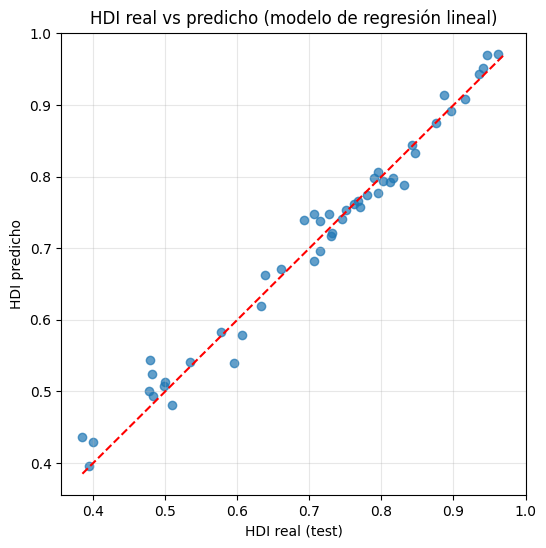

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("HDI real (test)")
plt.ylabel("HDI predicho")
plt.title("HDI real vs predicho (modelo de regresión lineal)")
plt.grid(True, alpha=0.3)
plt.show()

## 8. Conclusiones

- El HDI global muestra una **tendencia creciente** en las últimas décadas, aunque algunos países presentan estancamiento o retrocesos.  
- La **salud** (esperanza de vida) y la **educación** (años esperados y promedio de escolaridad) son los factores más fuertemente relacionados con el nivel de HDI.  
- Existen países con **ingresos muy elevados** pero con un desarrollo humano por debajo de lo esperado, lo que evidencia que el crecimiento económico, por sí solo, no garantiza bienestar.  
- El modelo de regresión lineal ofrece una aproximación razonable para predecir el HDI a partir de variables socioeconómicas básicas, aunque no captura toda la complejidad del desarrollo humano.
